<a href="https://colab.research.google.com/github/chadeowen/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4 - Chad Owen

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

# Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

## Load data

In [2]:
# TODO

# Data loaded

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'

import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv(data_url,header=None,names=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16'])
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Validate Observations

In [3]:
# Observations validated

df.shape

(690, 16)

## Confirm Missing

In [4]:
df.isna().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64

In [5]:
# Missing data

df.replace('?',np.nan,inplace=True)
df.isna().sum()

A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

## Correct dtypes

In [15]:
df.dtypes

A1      object
A2      object
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14     object
A15      int64
A16     object
dtype: object

In [0]:
df['A2']=df.A2.astype('float')

In [0]:
df['A11']=df.A11.astype('float')
df['A14']=df.A14.astype('float')
df['A15']=df.A15.astype('float')

In [19]:
# Loaded features are correct

df.dtypes

A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11    float64
A12     object
A13     object
A14    float64
A15    float64
A16     object
dtype: object

## Extra: remove NaNs and analysis

In [0]:
# Not many NaNs, Removal

df = df.dropna()

In [30]:
df.isna().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64

In [31]:
# Only lost 37 rows

df.shape

(653, 16)

In [32]:
# Original class distribution = 55.5% minus, 44.5% plus
# New class distribution = 54.7% minus, 45.3% plus

df['A16'].value_counts()

-    357
+    296
Name: A16, dtype: int64

# Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

## T Testing with Continuous Features

### Getting acquainted with data

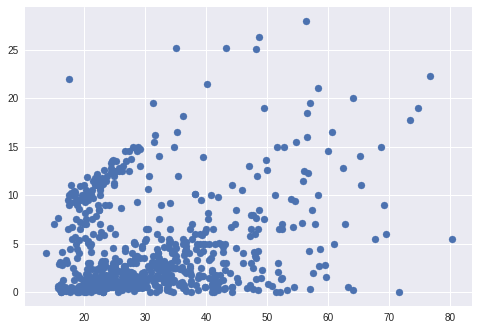

In [27]:
# TODO

import matplotlib.pyplot as plt

plt.scatter(df['A2'],df['A3']);

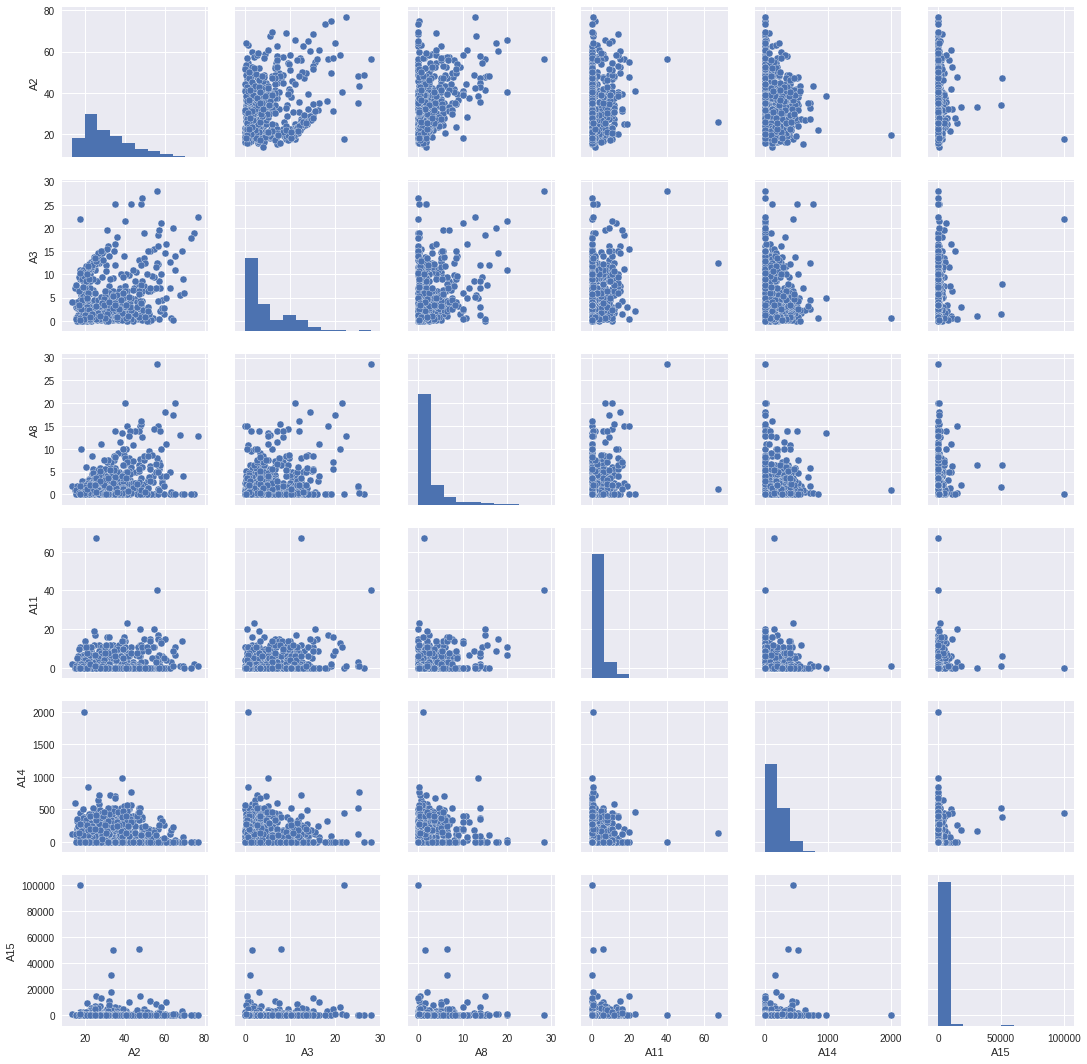

In [66]:
sns.pairplot(data=df);

In [37]:
good = df[df['A16'] == '+']
good.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,+


In [38]:
good.shape

(296, 16)

In [41]:
bad = df[df['A16'] == '-']
bad.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
70,b,32.33,7.50,u,g,e,bb,1.585,t,f,0.0,t,s,420.0,0.0,-
72,a,38.58,5.00,u,g,cc,v,13.500,t,f,0.0,t,g,980.0,0.0,-
73,b,44.25,0.50,u,g,m,v,10.750,t,f,0.0,f,s,400.0,0.0,-
74,b,44.83,7.00,y,p,c,v,1.625,f,f,0.0,f,g,160.0,2.0,-
75,b,20.67,5.29,u,g,q,v,0.375,t,t,1.0,f,g,160.0,0.0,-


In [42]:
bad.shape

(357, 16)

In [48]:
good.describe()

# A15, A11 has massive discrepencies

,A2,A3,A8,A11,A14,A15
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,33.845473,5.971943,3.475186,4.716216,164.621622,2009.726351
std,12.689357,5.492651,4.167399,6.398136,162.543550,7660.949172
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.250000,1.500000,0.750000,0.000000,0.000000,0.000000
50%,31.040000,4.480000,2.000000,3.000000,120.000000,210.500000
75%,41.440000,9.561250,5.000000,7.000000,280.000000,1216.500000
max,76.750000,28.000000,28.500000,67.000000,840.000000,100000.000000


In [46]:
bad.describe()

,A2,A3,A8,A11,A14,A15
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,29.562269,3.882325,1.223725,0.666667,193.408964,187.974790
std,10.719168,4.393079,2.029272,1.958368,172.057953,632.781715
min,15.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.920000,0.835000,0.125000,0.000000,100.000000,0.000000
50%,26.920000,2.210000,0.455000,0.000000,160.000000,1.000000
75%,34.830000,5.000000,1.500000,0.000000,260.000000,67.000000
max,74.830000,26.335000,13.875000,20.000000,2000.000000,5552.000000


### Most extreme result

In [56]:
import scipy

# Most Extreme
# Almost all zeroes for bad ratings but also zeroes on below 1Q for high ratings
# Credit age? Prevous number of accounts opened?

scipy.stats.ttest_ind(good['A11'],bad['A11'])

Ttest_indResult(statistic=11.336964562239809, pvalue=2.5864649620278843e-27)

### Other tests

In [57]:
scipy.stats.ttest_ind(good['A15'],bad['A15'])

Ttest_indResult(statistic=4.475369764700449, pvalue=9.003915641872878e-06)

In [62]:
scipy.stats.ttest_ind(good['A2'],bad['A2'])

Ttest_indResult(statistic=4.675662433767456, pvalue=3.5636710933835225e-06)

In [63]:
scipy.stats.ttest_ind(good['A3'],bad['A3'])

Ttest_indResult(statistic=5.400813416576192, pvalue=9.310154396147606e-08)

In [64]:
scipy.stats.ttest_ind(good['A8'],bad['A8'])

Ttest_indResult(statistic=9.002392498622463, pvalue=2.4079238505859142e-18)

### Least extreme result

In [65]:
# Least Extreme
# Interestingly, the one attribute where bad ratings are higher
# Default potential?

scipy.stats.ttest_ind(good['A14'],bad['A14'])

Ttest_indResult(statistic=-2.18221936438708, pvalue=0.029450100409286473)

## Chi Square Testing with Categorical Features: A1 versus...

### Least extreme result

In [0]:
A1 = pd.crosstab(df.A16,df.A1)

In [101]:
A1.head()

A1,a,b
A16,,
+,95,201
-,108,249


In [102]:
scipy.stats.chisquare(A1)

Power_divergenceResult(statistic=array([0.83251232, 5.12      ]), pvalue=array([0.36154707, 0.02365162]))

### other tests

####A4

In [0]:
A4 = pd.crosstab(df.A16,df.A4)

In [104]:
A4.head()

A4,l,u,y
A16,,,
+,2,249,45
-,0,250,107


In [105]:
scipy.stats.chisquare(A4)

Power_divergenceResult(statistic=array([2.00000000e+00, 2.00400802e-03, 2.52894737e+01]), pvalue=array([1.57299207e-01, 9.64293708e-01, 4.93394027e-07]))

####A5: GGs and half as many Ps for +s, 

In [0]:
A5 = pd.crosstab(df.A16,df.A5)

In [99]:
A5.head()

A5,g,gg,p
A16,,,
+,249,2,45
-,250,0,107


In [98]:
scipy.stats.chisquare(A5)

Power_divergenceResult(statistic=array([2.00400802e-03, 2.00000000e+00, 2.52894737e+01]), pvalue=array([9.64293708e-01, 1.57299207e-01, 4.93394027e-07]))

####A6: run chi^2

In [0]:
A6 = pd.crosstab(df.A16,df.A6)

In [107]:
A6.head()

A6,aa,c,cc,d,e,ff,i,j,k,m,q,r,w,x
A16,,,,,,,,,,,,,,
+,19,60,29,7,14,7,14,3,13,16,49,2,33,30
-,33,73,11,19,10,43,41,7,35,22,26,1,30,6


In [108]:
scipy.stats.chisquare(A6)

Power_divergenceResult(statistic=array([ 3.76923077,  1.27067669,  8.1       ,  5.53846154,  0.66666667,
       25.92      , 13.25454545,  1.6       , 10.08333333,  0.94736842,
        7.05333333,  0.33333333,  0.14285714, 16.        ]), pvalue=array([5.22036353e-02, 2.59639771e-01, 4.42652586e-03, 1.86029299e-02,
       4.14216178e-01, 3.55862993e-07, 2.71919712e-04, 2.05903211e-01,
       1.49616429e-03, 3.30390049e-01, 7.91178868e-03, 5.63702862e-01,
       7.05456986e-01, 6.33424837e-05]))

####A7: run chi^2

In [0]:
A7 = pd.crosstab(df.A16,df.A7)

In [110]:
A7.head()

A7,bb,dd,ff,h,j,n,o,v,z
A16,,,,,,,,,
+,24,2,8,87,3,2,1,163,6
-,29,4,46,50,5,2,1,218,2


In [111]:
scipy.stats.chisquare(A7)

Power_divergenceResult(statistic=array([ 0.47169811,  0.66666667, 26.74074074,  9.99270073,  0.5       ,
        0.        ,  0.        ,  7.93963255,  2.        ]), pvalue=array([4.92206993e-01, 4.14216178e-01, 2.32663921e-07, 1.57161938e-03,
       4.79500122e-01, 1.00000000e+00, 1.00000000e+00, 4.83636543e-03,
       1.57299207e-01]))

###A9: Most extreme result

In [0]:
A9 = pd.crosstab(df.A16,df.A9)

In [113]:
A9.head()

A9,f,t
A16,,
+,18,278
-,286,71


In [114]:
scipy.stats.chisquare(A9)

Power_divergenceResult(statistic=array([236.26315789, 122.7765043 ]), pvalue=array([2.56761592e-53, 1.56075696e-28]))

### more tests

####A10: opposite distributions

In [0]:
A10 = pd.crosstab(df.A16,df.A10)

In [116]:
A10.head()

A10,f,t
A16,,
+,93,203
-,273,84


In [117]:
scipy.stats.chisquare(A10)

Power_divergenceResult(statistic=array([88.52459016, 49.34146341]), pvalue=array([5.02068601e-21, 2.15068317e-12]))

####A12

In [0]:
A12 = pd.crosstab(df.A16,df.A12)

In [119]:
A12.head()

A12,f,t
A16,,
+,151,145
-,200,157


In [120]:
scipy.stats.chisquare(A12)

Power_divergenceResult(statistic=array([6.84045584, 0.47682119]), pvalue=array([0.00891161, 0.48986573]))

####A13

In [0]:
A13 = pd.crosstab(df.A16,df.A13)

In [122]:
A13.head()

A13,g,p,s
A16,,,
+,280,1,15
-,318,1,38


In [123]:
scipy.stats.chisquare(A13)

Power_divergenceResult(statistic=array([2.41471572, 0.        , 9.98113208]), pvalue=array([0.12019979, 1.        , 0.00158152]))

# Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

*Your words here!*

1) After separating good and bad ratings I ran t-tests on the different outcomes of A11 and A14. 
- A11s results were the most extreme with a p-value of ~1e^-27. Bad credit scores contained almost completely zero values, however, there were also all zeroes at the first quartile and below for the high credit scores. This leads me to believe that the value could measure the age of credit history or the previous number of accounts opened. Longer history and more accounts both increase your credit score, but the overall effect is minimum on a +/- rating.
- A14s results were the least extreme with a p-value of ~.024. Interestingly, this was the one continuous attribute where bad ratings had higher scores than good ratings. This lead me to believe it could be measuring default potential or the number of late payments.

2) After using crosstabulation over good and bad ratings I ran chi square tests on the different outcomes of A1 and A9.
- A1 was the least extreme result with p-values of ~.35 and ~.023 for values 'a' and 'b', respectively. Because this of the randomness, column, and variable names, I have a feeling this represents sex.
- A9 was the most extreme result with p-values of ~2.5e^53 and ~1.5e^-28. The value names are 'f' and 't' leading me to believe they signify false and true, respectively. There are many more trues than falses for the good ratings and visa versa for the bad. I don't believe there is enough information to infer what the attributes might signify an answer to.

3) The most challenging part of this exercise was running all of the tests. I am sure there is a way to more easily iterate through the values instead of copying and pasting line after line of code, but I was crunched for time and stuck with what I knew. Also, apologies on the lack of effort put into my LaTex notation with the exponents above ^ ... this too would have improved given a bit more time.